In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from json import loads

In [3]:
def plot_states(colors):

    indexes_dict = labeled_data_test.groupby('state').indices
    
    for key in indexes_dict:
        new_list = []
        
        prev_ind = indexes_dict[key][0]
        new_list.append(prev_ind)

        for inds in indexes_dict[key][1:]:
            

            if inds - prev_ind > 1 : # plot backgroud color for new state
                new_list.append(prev_ind)

                plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                new_list = []
                new_list.append(inds)

            if inds == indexes_dict[key][-1]: # plot backgroud color for las state

                new_list.append(inds)

                plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

            prev_ind = inds

def plot_accuracy_likelihood(prediction_window, rolling_window):

    print(f"Steps {prediction_window} - MA Window {rolling_window}")
    scaler = MinMaxScaler() 
    accuracy_scaled = scaler.fit_transform(labeled_data_test[f'accuracy - {prediction_window} step'].rolling(rolling_window).mean().values.reshape(-1, 1))
    log_likelihood_scaled = scaler.fit_transform(labeled_data_test[f'log_likelihood - {prediction_window} step'].values.reshape(-1, 1))

    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(accuracy_scaled, color='black', label='Accuracy')
    plt.plot(log_likelihood_scaled, color='b', label='Log Likelihood')
    
    colors = {'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'plum', 'mining': 'peachpuff', 'stream': 'silver'}
    print(colors)
    plot_states(colors)

    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [5]:
feature_names = 'cpu-all_mem'

model_names = ['rvp_random_48hr','rvp_pattern_48hr','rvp_random_48hr_2','rvp_pattern_48hr_2','rvp_random_48hr_3']

data_associations_dict = {'RPi4B8GB':{'freq':1800,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B4GB':{'freq':1500,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B2GB2':{'freq':1500,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B2GB1':{'freq':1200,'train_data':{},'test_data':{},'features':feature_names}} 

lookback = 300

In [6]:
"""Prepare data dict"""
for device in data_associations_dict:
    try:
        for model in model_names:
            data_associations_dict[device]['train_data'][model] = (pd.read_csv(f"data/{device}/{device}_{data_associations_dict[device]['freq']}MHz_res_usage_data_train_pred_{model}.csv"))
            labeled_data_test = pd.read_csv(f"data/{device}/{device}_{data_associations_dict[device]['freq']}MHz_res_usage_data_test_pred_{model}.csv")
            data_associations_dict[device]['test_data'][model] = (labeled_data_test[lookback:]) # remove lookback section
    except:
        pass

In [7]:
"""Training Classification Accuracy"""
train_accuracy_states = {}

for device in data_associations_dict:
    print(device)
    train_accuracy_states[device] = {}
    for model in data_associations_dict[device]['train_data']:
        print(model)
        train_accuracy_states[device][model] = []
        for name,group in data_associations_dict[device]['train_data'][model].groupby('state'):
            print(name)
            label = data_associations_dict[device]['train_data'][model].groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
            print(label)
            train_accuracy_states[device][model].append(label.max())

RPi4B8GB
rvp_random_48hr
augmented_reality
3    0.986381
0    0.013619
Name: predicted, dtype: float64
game
4    0.983768
0    0.016232
Name: predicted, dtype: float64
idle
5    0.987851
0    0.012149
Name: predicted, dtype: float64
mining
6    0.962171
0    0.037829
Name: predicted, dtype: float64
stream
2    0.949514
0    0.050486
Name: predicted, dtype: float64
rvp_pattern_48hr
augmented_reality
2    0.986807
5    0.013054
0    0.000139
Name: predicted, dtype: float64
game
0    0.988811
5    0.011070
4    0.000119
Name: predicted, dtype: float64
idle
6    0.988877
5    0.011123
Name: predicted, dtype: float64
mining
1    0.748436
4    0.234885
5    0.016678
Name: predicted, dtype: float64
stream
3    0.948411
5    0.051589
Name: predicted, dtype: float64
rvp_random_48hr_2
augmented_reality
0    0.987266
5    0.012503
6    0.000232
Name: predicted, dtype: float64
game
4    0.988611
5    0.011219
0    0.000170
Name: predicted, dtype: float64
idle
6    0.97878
5    0.02122
Name: predic

In [8]:
"""Testing Classification Accuracy"""
test_accuracy_states = {}
for device in data_associations_dict:
    print(device)
    test_accuracy_states[device] = {}
    for model in data_associations_dict[device]['test_data']:
        print(model)
        test_accuracy_states[device][model] = []
        for name,group in data_associations_dict[device]['test_data'][model].groupby('state'):
            print(name)
            label = data_associations_dict[device]['test_data'][model].groupby('state').get_group(name)[f'predicted states - {1} step'].value_counts(normalize=True)
            test_accuracy_states[device][model].append(label.max())
            print(label)

RPi4B8GB
rvp_random_48hr
augmented_reality
[3]    0.942321
[0]    0.050035
[6]    0.004864
[4]    0.002085
[2]    0.000695
Name: predicted states - 1 step, dtype: float64
game
[4]    0.941282
[0]    0.055722
[3]    0.001198
[2]    0.000599
[5]    0.000599
[6]    0.000599
Name: predicted states - 1 step, dtype: float64
idle
[5]    0.927596
[0]    0.065282
[6]    0.002374
[3]    0.001780
[4]    0.001780
[2]    0.001187
Name: predicted states - 1 step, dtype: float64
mining
[6]    0.934034
[0]    0.045306
[5]    0.009786
[2]    0.004712
[3]    0.003625
[4]    0.002537
Name: predicted states - 1 step, dtype: float64
stream
[2]    0.922468
[0]    0.057524
[6]    0.005836
[4]    0.005419
[5]    0.005002
[3]    0.003752
Name: predicted states - 1 step, dtype: float64
rvp_pattern_48hr
augmented_reality
[2]    0.941391
[5]    0.049509
[3]    0.004732
[0]    0.002912
[6]    0.000728
[4]    0.000364
[1]    0.000364
Name: predicted states - 1 step, dtype: float64
game
[0]    0.963719
[5]    0.0314

In [10]:
"""Analysis of Predictions"""
prediction_windows = [1,2,5,10,15,30,60]

test_accuracy = {}

for device in data_associations_dict:
    print(device)
    test_accuracy[device] = {}
    for model in data_associations_dict[device]['test_data']:
        print(model)
        test_accuracy[device][model] = []
        for prediction_window in prediction_windows:
            accuracy = []

            for index, row in data_associations_dict[device]['test_data'][model].iterrows():
                if type(row[f'label - {prediction_window} step']) == str:
                    accuracy.append(accuracy_score(loads(row[f'label - {prediction_window} step']), loads(row[f'predicted states - {prediction_window} step']))*100)
                else:
                    accuracy.append(accuracy_score(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'])*100)
            data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy
            mean_accuracy = round(mean(accuracy),2)
            test_accuracy[device][model].append(mean_accuracy)
            print(f"{prediction_window} step prediction accuracy: {mean_accuracy}%")
            #plot_accuracy_likelihood(prediction_window, 100)

RPi4B8GB
rvp_random_48hr
1 step prediction accuracy: 93.26%
2 step prediction accuracy: 91.73%
5 step prediction accuracy: 88.1%
10 step prediction accuracy: 83.33%
15 step prediction accuracy: 80.45%
30 step prediction accuracy: 73.49%
60 step prediction accuracy: 62.42%
rvp_pattern_48hr
1 step prediction accuracy: 92.1%
2 step prediction accuracy: 90.19%
5 step prediction accuracy: 85.77%
10 step prediction accuracy: 81.23%
15 step prediction accuracy: 78.33%
30 step prediction accuracy: 71.2%
60 step prediction accuracy: 59.77%
rvp_random_48hr_2
1 step prediction accuracy: 89.9%
2 step prediction accuracy: 87.85%
5 step prediction accuracy: 82.56%
10 step prediction accuracy: 77.48%
15 step prediction accuracy: 73.02%
30 step prediction accuracy: 65.18%
60 step prediction accuracy: 53.47%
rvp_pattern_48hr_2
1 step prediction accuracy: 90.19%
2 step prediction accuracy: 88.79%
5 step prediction accuracy: 85.05%
10 step prediction accuracy: 80.63%
15 step prediction accuracy: 77.78%
3

<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


1 step prediction accuracy: 69.82%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


2 step prediction accuracy: 69.15%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


5 step prediction accuracy: 66.85%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


10 step prediction accuracy: 64.45%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


15 step prediction accuracy: 61.86%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


30 step prediction accuracy: 56.65%
60 step prediction accuracy: 46.34%


<ipython-input-10-30cc73380851>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


RPi4B8GB_1800
RPi4B4GB_1500
RPi4B2GB2_1500
RPi4B2GB1_1200


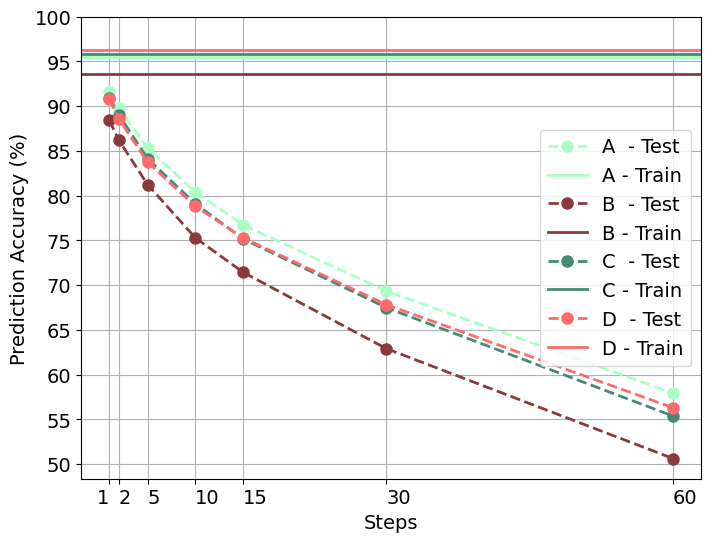

random  average train accuracy
95.28311548978253
random  average test accuracy
[90.42625000000001, 88.39999999999999, 83.6125, 78.40625, 74.65125, 66.88375, 55.05875]
RPi4B8GB_1800
RPi4B4GB_1500
RPi4B2GB2_1500
RPi4B2GB1_1200


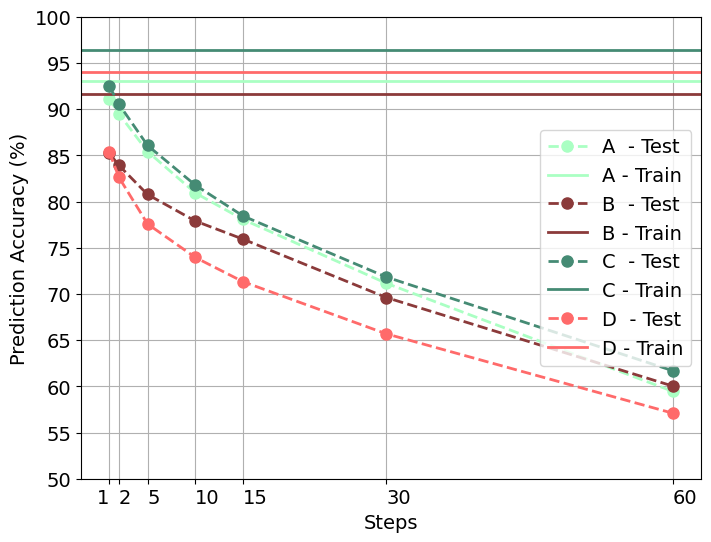

pattern  average train accuracy
93.7684897325058
pattern  average test accuracy
[88.54750000000001, 86.6425, 82.45375, 78.63625, 75.93375, 69.56625, 59.55749999999999]
overall average train accuracy
94.52580261114417
overall average test accuracy
[89.48687500000001, 87.52125, 83.033125, 78.52125000000001, 75.2925, 68.225, 57.308125]


In [11]:
def get_label(old_label):

    if old_label == 'random':
        return'Random'
    elif old_label == 'pattern':
        return'Pattern'
    elif old_label == 'RPi4B8GB':
        return'A'
    elif old_label == 'RPi4B4GB':
        return'B'
    elif old_label == 'RPi4B2GB2':
        return'C'
    elif old_label == 'RPi4B2GB1':
        return'D'


def get_color(dev):
    # '#aaffc3', '#8B3A3A', '#458B74', '#FF6A6A'
    if dev == 'RPi4B8GB': 
        return '#aaffc3'
    elif dev == 'RPi4B4GB':
        return '#8B3A3A'
    elif dev == 'RPi4B2GB2':
        return '#458B74'
    elif dev == 'RPi4B2GB1':    
        return '#FF6A6A'
    

import matplotlib.pyplot as plt

prediction_windows = [1,2,5,10,15,30,60]
sequence_type = ['random', 'pattern']
sq_test_accuracies, sq_train_accuracies = [], []
for sq_type in sequence_type:
    
    fig, ax = plt.subplots(figsize =(8, 6))
    plt.rcParams.update({'font.size': 14})
    test_accuracyies_list, train_accuracyies_list = [], []
    for device in test_accuracy:
        
        
        
        for model in test_accuracy[device]:
            if sq_type in model and '2' not in model:
                test_1 = test_accuracy[device][model]
                test_states_1 = test_accuracy_states[device][model]
                train_states_1 = train_accuracy_states[device][model]
            elif sq_type in model and '2' in model and '2GB1' not in device:
                test_2 = test_accuracy[device][model]
                test_states_2 = test_accuracy_states[device][model]
                train_states_2 = train_accuracy_states[device][model]
            elif sq_type in model and '3' in model and '2GB1' in device:
                test_2 = test_accuracy[device][model]
                test_states_2 = test_accuracy_states[device][model]
                train_states_2 = train_accuracy_states[device][model]

        print(f'{device}_{data_associations_dict[device]["freq"]}')

        
        #print('Avg')
        
        plt.plot(prediction_windows,[(t1 + t2) / 2 for t1, t2 in zip(test_1, test_2)], marker='o', markersize = 8, color = get_color(device) , linewidth = 2, linestyle = '--', label = f'{get_label(device)}  - Test')
        test_accuracyies_list.append([(t1 + t2) / 2 for t1, t2 in zip(test_1, test_2)])
        plt.axhline(mean([(ts1 + ts2) / 2 for ts1, ts2 in zip(train_states_1, train_states_2)])*100, linewidth = 2, color = get_color(device),label= f'{get_label(device)} - Train')
        train_accuracyies_list.append(mean([(ts1 + ts2) / 2 for ts1, ts2 in zip(train_states_1, train_states_2)])*100)

    plt.legend(loc='center right')
    plt.ylabel('Prediction Accuracy (%)')
    plt.xlabel('Steps')
    #plt.title(get_label(sq_type) + ' State Sequence')
    plt.grid()
    plt.yticks(np.arange(50, 105, 5))
    plt.xticks(prediction_windows)
    plt.setp(ax.xaxis.get_majorticklabels()[0],ha="right" )
    plt.setp(ax.xaxis.get_majorticklabels()[1:],ha="left" )
    
    plt.show() 
    print(sq_type, ' average train accuracy')
    print(sum(train_accuracyies_list) / len(train_accuracyies_list))
    sq_train_accuracies.append(sum(train_accuracyies_list) / len(train_accuracyies_list))

    print(sq_type, ' average test accuracy')
    print([sum(acc_sub_list) / len(acc_sub_list) for acc_sub_list in zip(*test_accuracyies_list)])
    sq_test_accuracies.append([sum(acc_sub_list) / len(acc_sub_list) for acc_sub_list in zip(*test_accuracyies_list)])
    """
    print('1')
    plt.plot(prediction_windows,test_1, marker='o', markersize = 8 , linewidth = 3, color ='limegreen', label = f'{get_label(device)} - {get_label(sq_type)} - Test')
    plt.axhline(mean(train_states_1)*100, linewidth = 3, color ='orange',label= f'{get_label(device)} - {get_label(sq_type)} - Train')
    plt.legend(loc='upper right')
    plt.ylabel('Percent Accuracy')
    plt.xlabel('Steps')
    plt.grid()
    plt.yticks(np.arange(50, 105, 5))
    plt.xticks(prediction_windows)
    plt.show() 

    print('2')
    plt.plot(prediction_windows,test_2, linewidth = 3, color ='orange',label= f'{get_label(device)} - {get_label(sq_type)} - Train')
    plt.axhline(mean(train_states_1)*100, linewidth = 3, color ='orange',label= f'{get_label(device)} - {get_label(sq_type)} - Train')
    plt.legend(loc='upper right')
    plt.ylabel('Percent Accuracy')
    plt.xlabel('Steps')
    plt.grid()
    plt.xticks(prediction_windows)
    plt.yticks(np.arange(50, 105, 5))
    plt.show()

    """


print('overall average train accuracy')
print(sum(sq_train_accuracies) / len(sq_train_accuracies))
   

print('overall average test accuracy')
print([sum(acc_sub_list) / len(acc_sub_list) for acc_sub_list in zip(*sq_test_accuracies)])